In [41]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
from sklearn.model_selection import train_test_split

In [28]:
dataset = pd.read_csv("datasets/dataset.csv")

In [29]:
sample_size = 50000
vecteur = random.sample(range(len(dataset)), sample_size)

In [36]:
X = np.array(dataset.iloc[vecteur].review_text, dtype = "str")
y = dataset.iloc[vecteur].review_score

In [60]:
y[y == -1] = 0

C:\Users\natha\AppData\Local\Temp\ipykernel_2908\3153561895.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y == -1] = 0


In [38]:
X[:10]

array(['Addicting', ' Early Access Review',
       'Kids version of Grand Theft Auto        10/10 Hasbro Preschool',
       "After Assassin's Creed 3 i was really skeptical about buying this one, but im sure as hell glad i did. Ive yet to complete the game, but from what ive completed so far i can say that the gameplay is the usually, fights are the same, scaling buildings is about the same speed as Assassin's Creed 3, the ship battles are better, and its all about pirates! also the world itself seems HUGE compared to other Assassin's Creed games because of the addition of islands and sea adventures. Another note is that Assassin's Creeed 4 manages to bring back the mystery that the previous installments of the AC series of seemed to lack. Just like AC 2 (the best one IMO) the game sets you up with a sleuth of information waiting to be found and decoded through video and recorded messages left over from desmond and research teams of abstergo.",
       'the way of ......................

In [61]:
y.head(10)

4157243    1
4042243    1
4008485    1
2322371    1
1828782    1
6093342    1
20108      1
1951111    1
507883     0
2700364    1
Name: review_score, dtype: int64

In [62]:
X_train, X_test_full, y_train, y_test_full = train_test_split(X, y, train_size = 0.6, random_state = 42)

In [63]:
X_val, y_val = X_test_full[:int(len(X_test_full)/2)], y_test_full[:int(len(X_test_full)/2)]
X_test, y_test = X_test_full[int(len(X_test_full)/2):], y_test_full[int(len(X_test_full)/2):]

In [64]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(30000,) (10000,) (10000,)
(30000,) (10000,) (10000,)


In [65]:
tokenizer = Tokenizer(num_words = 4000, oov_token = "UNKNOWN")
tokenizer.fit_on_texts(X_train)

In [ ]:
import matplotlib.pyplot as plt
list_count = list(sorted(tokenizer.word_counts.values()))
list_count.reverse()

In [ ]:
list_count[1000]/sample_size

0.00345

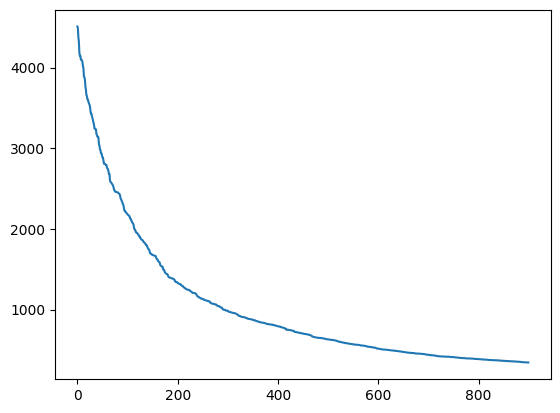

In [ ]:
plt.plot(list_count[100:1000])

In [ ]:
import pandas as pd
test_serie = pd.Series(tokenizer.index_word)
test_serie

1              UNK
2              the
3              and
4                a
5               to
           ...    
66394    dissagree
66395        rymes
66396        tiems
66397       casing
66398        alhoa
Length: 66398, dtype: object

In [66]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

(array([21569.,  3880.,  1778.,   938.,   507.,   373.,   258.,   152.,
          123.,    79.]),
 array([  0.,  50., 100., 150., 200., 250., 300., 350., 400., 450., 500.]),
 <BarContainer object of 10 artists>)

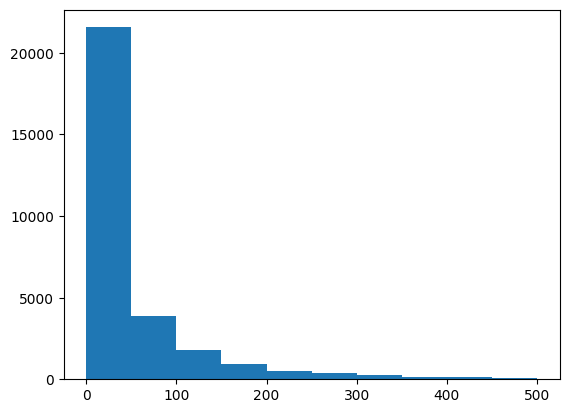

In [67]:
import matplotlib.pyplot as plt
plt.hist([len(x) for x in X_train_sequences], bins = 10, range = [0, 500])

In [54]:
X_train_padded = pad_sequences(X_train_sequences, maxlen = 400)
X_val_padded = pad_sequences(X_val_sequences, maxlen = 400)
X_test_padded = pad_sequences(X_test_sequences, maxlen = 400)

In [56]:
print(X_train_padded.shape, X_val_padded.shape, X_test_padded.shape)

(30000, 400) (10000, 400) (10000, 400)


In [57]:
from keras.layers import Input, Embedding, MultiHeadAttention, LayerNormalization, Dense, Flatten
from keras.models import Model
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryAccuracy

In [68]:
token_projection_dim = 64

input_layer = Input(shape = [400,], dtype = 'int64')

embedding_layer = Embedding(input_dim = 4000, input_length = 400, output_dim = token_projection_dim)(input_layer)

MHA_layer = MultiHeadAttention(num_heads = 2, dropout = 0.1, key_dim = token_projection_dim)(embedding_layer, embedding_layer, embedding_layer)

normalization_layer1 = LayerNormalization(epsilon = 1e-6)(embedding_layer + MHA_layer)

dense_layer1 = Dense(token_projection_dim, activation = "tanh")(normalization_layer1)

dense_layer2 = Dense(token_projection_dim, activation = "tanh")(dense_layer1)

normalization_layer2 = LayerNormalization(epsilon = 1e-6)(normalization_layer1 + dense_layer2)

flatten_layer = Flatten()(normalization_layer2)

output_layer = Dense(1, activation = "sigmoid")(flatten_layer)

model = Model(inputs = input_layer, outputs = output_layer)

model.compile(optimizer = Adam(learning_rate = 0.001), loss = BinaryCrossentropy(), metrics = [BinaryAccuracy()])

# Model fitting
history = model.fit(X_train_padded, y_train, batch_size = 32, epochs = 5, validation_data = (X_val_padded, y_val))

Epoch 1/5


c:\Users\natha\Documents\Programmation\Git\game-reviews-sentiment-analysis\env\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


938/938 ━━━━━━━━━━━━━━━━━━━━ 82s 86ms/step - binary_accuracy: 0.7882 - loss: 0.6724 - val_binary_accuracy: 0.8475 - val_loss: 0.3605
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 80s 85ms/step - binary_accuracy: 0.8944 - loss: 0.2661 - val_binary_accuracy: 0.8549 - val_loss: 0.3872
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 79s 84ms/step - binary_accuracy: 0.9329 - loss: 0.1793 - val_binary_accuracy: 0.8506 - val_loss: 0.4542
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 79s 84ms/step - binary_accuracy: 0.9488 - loss: 0.1382 - val_binary_accuracy: 0.8451 - val_loss: 0.5196
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 76s 81ms/step - binary_accuracy: 0.9580 - loss: 0.1170 - val_binary_accuracy: 0.8407 - val_loss: 0.5539
